Mini-Project!
Statistical Modeling and Interpretation of Results in Churn Analysis!

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -q pandas==2.3.1 numpy==2.3.2 statsmodels==0.14.4 seaborn==0.13.2 matplotlib==3.8.0 plotly==5.24.1 ipython==8.30.0


ERROR: Cannot install matplotlib==3.8.0, numpy==2.3.2, pandas==2.3.1, seaborn==0.13.2 and statsmodels==0.14.4 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, Markdown

In [5]:
#config to better display the data
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [6]:
%reload_ext watermark
%watermark -a "Eduardo" -a "Data Engineer" -a "2025-10-20" -a "Mini-Project" -a "Statistical Modeling and Interpretation of Results in Churn Analysis"

Author: Statistical Modeling and Interpretation of Results in Churn Analysis



In [7]:
%watermark --iversions

matplotlib : 3.10.7
seaborn    : 0.13.2
pandas     : 2.3.1
IPython    : 9.6.0
numpy      : 2.3.4
plotly     : 6.3.1
statsmodels: 0.14.5



In [8]:
display(Markdown("""
## 2. Business Problem Definition

### **2.1. Business Problem**

**Conecta Telecom**, a fictitious telecommunications company, is facing a churn rate above the industry average.

Management needs clear, data-driven answers to the following question:
**What are the main factors that lead our customers to cancel their services?**

- We want to understand the relationship between variables → Statistical Modeling
- If we want to predict churn → Predictive Modeling

### **2.2. Project Objectives**

This project aims to use statistical modeling to analyze customer data and achieve the following objectives:

1. Identify Key Factors: Determine which variables (such as contract type, loyalty period, invoice amount) have a direct impact on churn.
2. Quantify the Impact: Measure the influence of each factor on churn risk.
3. Generate Recommendations: Translate the results of the statistical analysis into actionable business recommendations for creating customer retention strategies.

The model chosen for this analysis will be Logistic Regression, as our goal is to understand the relationship between several variables and a binary variable (churn or no churn).
"""))


## 2. Business Problem Definition

### **2.1. Business Problem**

**Conecta Telecom**, a fictitious telecommunications company, is facing a churn rate above the industry average.

Management needs clear, data-driven answers to the following question:
**What are the main factors that lead our customers to cancel their services?**

- We want to understand the relationship between variables → Statistical Modeling
- If we want to predict churn → Predictive Modeling

### **2.2. Project Objectives**

This project aims to use statistical modeling to analyze customer data and achieve the following objectives:

1. Identify Key Factors: Determine which variables (such as contract type, loyalty period, invoice amount) have a direct impact on churn.
2. Quantify the Impact: Measure the influence of each factor on churn risk.
3. Generate Recommendations: Translate the results of the statistical analysis into actionable business recommendations for creating customer retention strategies.

The model chosen for this analysis will be Logistic Regression, as our goal is to understand the relationship between several variables and a binary variable (churn or no churn).


In [9]:
def dsa_generate_churn_data(num_clients=2000):
    """
    Generates a DataFrame of fictitious customer data from a telecommunications company.
    """

    # For reproducibility
    np.random.seed(42)

    # Variables
    tenure_months = np.random.randint(1, 73, size=num_clients)

    contract_type_opts = ['Monthly', 'Annual', 'Two years']
    contract_probs = [0.6, 0.25, 0.15]
    contract_type = np.random.choice(contract_type_opts, size=num_clients, p=contract_probs)

    internet_service_opts = ['Fiber Optics', 'DSL', 'No']
    internet_probs = [0.55, 0.35, 0.10]
    internet_service = np.random.choice(internet_service_opts, size=num_clients, p=internet_probs)

    base_charge = {
        'Monthly': np.random.normal(60, 20),
        'Annual': np.random.normal(70, 25),
        'Two years': np.random.normal(80, 25)
    }

    monthly_charge = [
        base_charge[c] + tenure_months[i] * 0.2 + np.random.normal(0, 5)
        for i, c in enumerate(contract_type)
    ]
    monthly_charge = np.clip(monthly_charge, 20, 120)

    # Logic for churn probability
    prob_churn_log = -2.5
    prob_churn_log += -0.05 * tenure_months  # More loyalty, less chance of churn
    prob_churn_log += [3.0 if c == 'Monthly' else 1.5 if c == 'Annual' else 0 for c in contract_type]
    prob_churn_log += [0.8 if s == 'Fiber Optics' else -0.5 if s == 'DSL' else 0 for s in internet_service]
    prob_churn_log += 0.03 * np.array(monthly_charge)  # Higher bills, more chance of churn

    prob_churn = 1 / (1 + np.exp(-np.array(prob_churn_log)))
    churn = np.random.binomial(1, prob_churn)

    # Construct DataFrame
    df = pd.DataFrame({
        'CustomerID': range(1, num_clients + 1),
        'TenureMonths': tenure_months,
        'ContractType': contract_type,
        'InternetService': internet_service,
        'MonthlyCharge': monthly_charge,
        'Churn': churn
    })

    return df

In [10]:
# Generate data
df_churn = dsa_generate_churn_data()

In [11]:
display(Markdown("### Sample of Generated Data"))
display(df_churn.head())

### Sample of Generated Data

,CustomerID,TenureMonths,ContractType,InternetService,MonthlyCharge,Churn
0,1,52,Annual,Fiber Optics,36.5724,0
1,2,15,Two years,Fiber Optics,45.2871,0
2,3,72,Monthly,Fiber Optics,101.0033,1
3,4,61,Monthly,Fiber Optics,103.3314,1
4,5,21,Monthly,DSL,94.0969,1


## 4. Exploratory Data  (EDA)

In [12]:
# General dataframe information
display(Markdown("### General dataframe information"))
df_churn.info()

### General dataframe information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       2000 non-null   int64  
 1   TenureMonths     2000 non-null   int32  
 2   ContractType     2000 non-null   object 
 3   InternetService  2000 non-null   object 
 4   MonthlyCharge    2000 non-null   float64
 5   Churn            2000 non-null   int32  
dtypes: float64(1), int32(2), int64(1), object(2)
memory usage: 78.3+ KB


In [13]:
# Summary Statistical  of Numerical Variables
display(Markdown("### Statistical Summary of Numerical Variables"))
display(df_churn.describe())

### Statistical Summary of Numerical Variables

,CustomerID,TenureMonths,MonthlyCharge,Churn
count,2000.0000,2000.0000,2000.0000,2000.0000
mean,1000.5000,35.6825,75.3201,0.5655
std,577.4946,20.8430,27.5079,0.4958
min,1.0000,1.0000,24.9216,0.0000
25%,500.7500,17.0000,45.0201,0.0000
50%,1000.5000,35.0000,90.6543,1.0000
75%,1500.2500,54.0000,98.5286,1.0000
max,2000.0000,72.0000,119.2712,1.0000


## 4.1 Summary Statistics of Categorical Variables

In [14]:
# Summary Statistics of Categorical Variables
display(Markdown("### Summary Statistics of Categorical Variables"))
display(df_churn.describe(include=['object']))

### Summary Statistics of Categorical Variables

,ContractType,InternetService
count,2000,2000
unique,3,3
top,Monthly,Fiber Optics
freq,1186,1114


## 4.2 Overall Churn Rate Chart

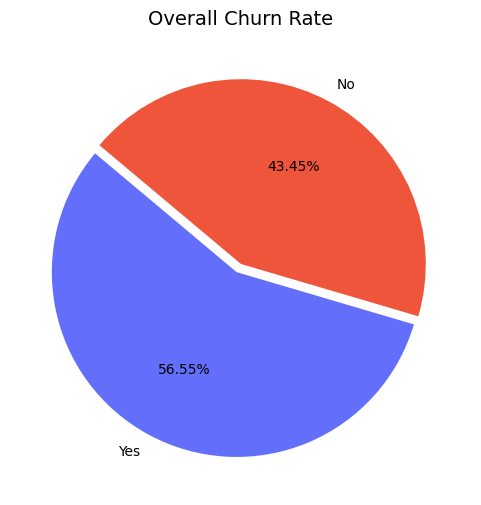

In [15]:
# Counts the values ​​in the 'Churn' column
churn_counts = df_churn['Churn'].value_counts().rename(index={1: 'Yes', 0: 'No'})

# Sets the colors equivalent to the original graph
colors = ['#636EFA', '#EF553B']

# Creates the pie chart with two decimal places
plt.figure(figsize=(6, 6))
plt.pie(
    churn_counts.values,
    labels=churn_counts.index,
    autopct='%1.2f%%',          # show percentage with 2 decimal places
    startangle=140,             # initial angle to rotate the graph
    colors=colors,
    explode=[0.05 if label == 'Yes' else 0 for label in churn_counts.index]  # highlights the "Yes" slice
)
plt.title('Overall Churn Rate', fontsize=14)
plt.show()

In [16]:
import plotly.io as pio
pio.renderers.default = "browser"

In [17]:
# Calculate count by category
churn_counts = df_churn['Churn'].value_counts()

# Create the graph
fig_pie = px.pie(
    values=churn_counts.values,
    names=churn_counts.index.map({1: 'Yes', 0: 'No'}),  # rename the categories
    title='Overall Churn Rate',
    color=churn_counts.index.map({1: 'Yes', 0: 'No'}),  # use the same categories for color
    color_discrete_map={'Yes': '#EF553B', 'No': '#636EFA'}  # define manual colors
)

# Show the chart
fig_pie.show()


In [18]:
# Calculate the churn rate
churn_counts = df_churn['Churn'].value_counts()
numerador = churn_counts.get(1, churn_counts.get('Yes', churn_counts.get(True, 0)))
taxa = 100 * numerador / len(df_churn) 

display(Markdown(f"""
The average churn rate in our database is {taxa: 2f}%.
This is our main indicator to analyze.
"""))


The average churn rate in our database is  56.550000%.
This is our main indicator to analyze.


## 4.3 Graph by Churn Rate by Type of Contract

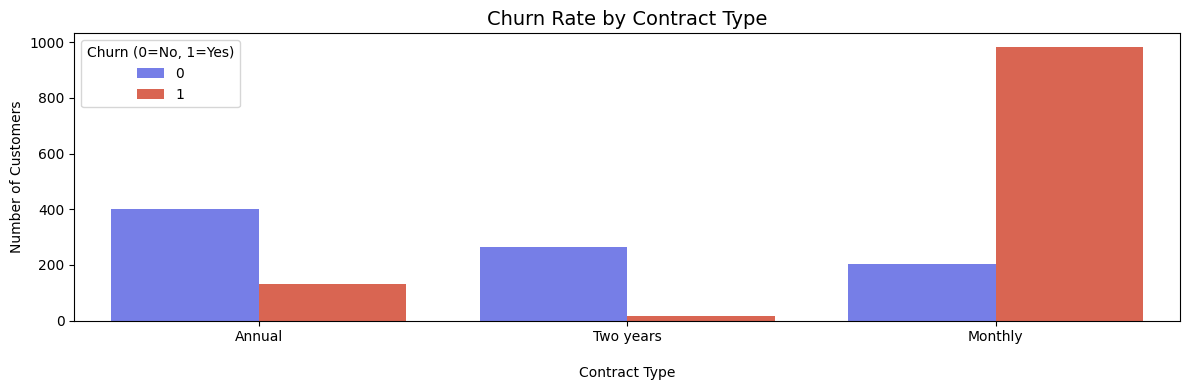

In [19]:
# Graphic -- static version
plt.figure(figsize=(12, 4))

# Creates the grouped bar chart with Seaborn
sns.countplot(data=df_churn,
              x='ContractType',
              hue='Churn',
              palette={0: '#636EFA', 1: '#EF553B'})

plt.title('Churn Rate by Contract Type', fontsize=14)
plt.xlabel('\nContract Type')
plt.ylabel('Number of Customers')
plt.legend(title='Churn (0=No, 1=Yes)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# The chance to a monthly contract churn is bigger than the other two.

In [20]:
# Graphic – Interactive Version

# Histogram
fig_bar_contract = px.histogram(df_churn,
                                x='ContractType',
                                color='Churn',
                                barmode='group',
                                title='Churn Rate by Contract Type',
                                labels={'ContractType': 'Contract Type','Churn': 'Churn (0=No, 1=Yes)'})
fig_bar_contract.show()

display(Markdown("""
**Insight:** The visualization is clear: customers with **monthly contracts** have a drastically higher churn tendency compared to customers with longer contracts.
"""))


## 4.4 Interactive Plotly Chart (Tenure vs Churn)

In [21]:
# Graphic – Interactive Version

# Analysis by Tenure (Loyalty)
dsa_fig_hist_tenure = px.histogram(df_churn,
                                x='TenureMonths',
                                color='Churn',
                                marginal='box',
                                title='Tenure (in Months) Distribution by Churn',
                                labels={'TenureMonths': 'Tenure (Months)', 'Churn': 'Churn (0=No, 1=Yes)'})

dsa_fig_hist_tenure.show()

In [22]:
display(Markdown("""
**Insight:** Customers who cancel the service (**Churn = 1**) are more concentrated in the first months of their contract.  
The median tenure for customers who churn is much lower than for those who stay.  
This indicates that the beginning of the customer journey is a critical period for retention.
"""))


**Insight:** Customers who cancel the service (**Churn = 1**) are more concentrated in the first months of their contract.  
The median tenure for customers who churn is much lower than for those who stay.  
This indicates that the beginning of the customer journey is a critical period for retention.


In [23]:
# Graphic – Interactive Version
# Analysis by Monthly Charges
fig_hist_monthly_charges = px.histogram(df_churn,
                                        x='MonthlyCharge',
                                        color='Churn',
                                        marginal='box',
                                        title='Distribution of Monthly Charges by Churn',
                                        labels={'MonthlyCharge': 'Monthly Charges Value($)'})

fig_hist_monthly_charges.show()

In [24]:
display(Markdown("""
**Insight:** Customers with higher monthly charges tend to have a higher churn rate.  
The median monthly charge value for customers who churned is noticeably higher than for those who stayed.
"""))


**Insight:** Customers with higher monthly charges tend to have a higher churn rate.  
The median monthly charge value for customers who churned is noticeably higher than for those who stayed.


### 5. Data Preparation for Statistical Modeling

In [25]:
# Original Data
display(df_churn.head())

,CustomerID,TenureMonths,ContractType,InternetService,MonthlyCharge,Churn
0,1,52,Annual,Fiber Optics,36.5724,0
1,2,15,Two years,Fiber Optics,45.2871,0
2,3,72,Monthly,Fiber Optics,101.0033,1
3,4,61,Monthly,Fiber Optics,103.3314,1
4,5,21,Monthly,DSL,94.0969,1


In [26]:
# Variable Categories
df_churn.ContractType.value_counts()

ContractType
Monthly      1186
Annual        533
Two years     281
Name: count, dtype: int64

In [27]:
# Variable Categories
df_churn.InternetService.value_counts()

InternetService
Fiber Optics    1114
DSL              690
No               196
Name: count, dtype: int64

In [28]:
# Preparation
# Convert categorical variables to dummy variables (0 or 1)
# Added the dtype=int parameter to ensure that the new columns are numeric
df_model = pd.get_dummies( df_churn, columns=['ContractType', 'InternetService'], drop_first=True, dtype=int)

Dummy variables (or indicator variables) are numerical variables created to represent categories in statistical or machine learning models.
They transform qualitative data (such as "gender," "marital status," "region") into numerical values ​​(usually 0 and 1), allowing mathematical algorithms to process them.
This technique is called One-Hot Encoding.

In [29]:
# Original data
df_churn.head()

,CustomerID,TenureMonths,ContractType,InternetService,MonthlyCharge,Churn
0,1,52,Annual,Fiber Optics,36.5724,0
1,2,15,Two years,Fiber Optics,45.2871,0
2,3,72,Monthly,Fiber Optics,101.0033,1
3,4,61,Monthly,Fiber Optics,103.3314,1
4,5,21,Monthly,DSL,94.0969,1


In [30]:
# Processed Data
df_model.head()

,CustomerID,TenureMonths,MonthlyCharge,Churn,ContractType_Monthly,ContractType_Two years,InternetService_Fiber Optics,InternetService_No
0,1,52,36.5724,0,0,0,1,0
1,2,15,45.2871,0,0,1,1,0
2,3,72,101.0033,1,1,0,1,0
3,4,61,103.3314,1,1,0,1,0
4,5,21,94.0969,1,1,0,0,0


In [31]:
# Data summary
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CustomerID                    2000 non-null   int64  
 1   TenureMonths                  2000 non-null   int32  
 2   MonthlyCharge                 2000 non-null   float64
 3   Churn                         2000 non-null   int32  
 4   ContractType_Monthly          2000 non-null   int64  
 5   ContractType_Two years        2000 non-null   int64  
 6   InternetService_Fiber Optics  2000 non-null   int64  
 7   InternetService_No            2000 non-null   int64  
dtypes: float64(1), int32(2), int64(5)
memory usage: 109.5 KB


In [32]:
# Define the variables
# Dependent variable (what we want to predict)
y = df_model['Churn']

In [33]:
# Independent variables (the ones we use to predict)
# We exclude the customer ID and the original target variable
X = df_model.drop(['CustomerID', 'Churn'], axis=1)

In [34]:
# Add a constant (intercept) to the model, required by the statsmodels library
X = sm.add_constant(X)

In [35]:
display(Markdown("Add a constant (intercept) to the model, required by the statsmodels library"))
display(X.head())

Add a constant (intercept) to the model, required by the statsmodels library

,const,TenureMonths,MonthlyCharge,ContractType_Monthly,ContractType_Two years,InternetService_Fiber Optics,InternetService_No
0,1.0000,52,36.5724,0,0,1,0
1,1.0000,15,45.2871,0,1,1,0
2,1.0000,72,101.0033,1,0,1,0
3,1.0000,61,103.3314,1,0,1,0
4,1.0000,21,94.0969,1,0,0,0


In [36]:
display(Markdown("### Sample Data (y) Prepared for the model"))
display(y.head())

### Sample Data (y) Prepared for the model

0    0
1    0
2    1
3    1
4    1
Name: Churn, dtype: int32

### 6. Statistical Modeling

In [38]:
display(Markdown("Let's build a model to quantify the impact of each variable on the probability of churn."))

# Create the model
model = sm.Logit(y, X)

Let's build a model to quantify the impact of each variable on the probability of churn.

In [39]:
type(model)

statsmodels.discrete.discrete_model.Logit

In [40]:
# Train the model
trained_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.373673
         Iterations 7


In [41]:
# Display the complete summary of the model
display(Markdown("### Results of the Logistic Regression Model"))
trained_model.summary()

### Results of the Logistic Regression Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1993
Method:                           MLE   Df Model:                            6
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                  0.4541
Time:                        13:46:45   Log-Likelihood:                -747.35
converged:                       True   LL-Null:                       -1369.1
Covariance Type:            nonrobust   LLR p-value:                1.861e-265
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.6644      0.488     -3.411      0.001      -2.621      -0.708
TenureMonths                    -0.0550      0.004    -12.234      0.000      -0.064      -0.046
MonthlyCharge                    0.0310      0.013      2.455      0.014       0.006       0.056
ContractType_Monthly             1.8077      0.694      2.604      0.009       0.447       3.169
ContractType_Two years          -1.8050      0.284     -6.354      0.000      -2.362      -1.248
InternetService_Fiber Optics     1.3669      0.147      9.280      0.000       1.078       1.656
InternetService_No               0.5421      0.235      2.305      0.021       0.081       1.003
================================================================================================
"""

In [42]:
display(Markdown("""
The summary above contains valuable insights about our model.  
Let's focus on the most important points for the business:

1. **Coefficients (coef):** Show the direction of the impact.  
   A positive coefficient increases the chance of churn, while a negative one decreases it.

2. **P-value (P > |z|):** Indicates the statistical significance of each variable.  
   A low p-value (usually < 0.05) means the effect of the variable is real and not just a random coincidence in the sample.

3. **Pseudo R-squared:** Similar to R² in linear regression, it indicates the proportion of the "variance" in the dependent variable explained by the model.  
   A value around 0.645 (or 65%) is considered a good fit for this type of model.

To make interpretation easier, we’ll calculate the **Odds Ratio**, which tells us how the chances of churn change with a one-unit increase in each independent variable.

The Odds Ratio is a measure used to compare the probability of an event occurring between two groups.  
It is very common in statistics and models such as logistic regression.

Simply put, the “odds” of an event are the ratio between the probability of it happening and not happening.  
For example, if the probability of a client making a purchase is 0.8 (80%), the odds are 0.8 / 0.2 = 4.  
That means the chance of purchase is four times higher than the chance of not purchasing.
"""))



The summary above contains valuable insights about our model.  
Let's focus on the most important points for the business:

1. **Coefficients (coef):** Show the direction of the impact.  
   A positive coefficient increases the chance of churn, while a negative one decreases it.

2. **P-value (P > |z|):** Indicates the statistical significance of each variable.  
   A low p-value (usually < 0.05) means the effect of the variable is real and not just a random coincidence in the sample.

3. **Pseudo R-squared:** Similar to R² in linear regression, it indicates the proportion of the "variance" in the dependent variable explained by the model.  
   A value around 0.645 (or 65%) is considered a good fit for this type of model.

To make interpretation easier, we’ll calculate the **Odds Ratio**, which tells us how the chances of churn change with a one-unit increase in each independent variable.

The Odds Ratio is a measure used to compare the probability of an event occurring between two groups.  
It is very common in statistics and models such as logistic regression.

Simply put, the “odds” of an event are the ratio between the probability of it happening and not happening.  
For example, if the probability of a client making a purchase is 0.8 (80%), the odds are 0.8 / 0.2 = 4.  
That means the chance of purchase is four times higher than the chance of not purchasing.


In [43]:
# Calculate and display the odds ratios (Odds Ratios)
params = trained_model.params
conf = trained_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
conf = np.exp(conf)

display(Markdown("### Odds Ratio Table"))
display(conf)


### Odds Ratio Table

,2.5%,97.5%,Odds Ratio
const,0.0728,0.4926,0.1893
TenureMonths,0.9382,0.9549,0.9465
MonthlyCharge,1.0063,1.0573,1.0315
ContractType_Monthly,1.5633,23.7722,6.0962
ContractType_Two years,0.0943,0.2870,0.1645
InternetService_Fiber Optics,2.9395,5.2365,3.9233
InternetService_No,1.0845,2.7267,1.7196


In [46]:
display(Markdown("""
### Interpretation of the Odds Ratio for the Business:

1. **const (intercept)**  
   The value **0.1893** represents the base churn odds when all other variables are zero.  
   It doesn’t have a practical meaning, serving only as a reference baseline for the model.

2. **TenureMonths (0.9465)**  
   The odds ratio below 1 indicates a protective effect:  
   the longer the customer stays (higher tenure), the lower the chance of churn.  
   Each additional month reduces churn likelihood by roughly **(1 - 0.9465) × 100 = 5.35%**.

3. **MonthlyCharge (1.0315)**  
   A value slightly above 1 means that higher monthly bills increase the chance of churn.  
   For each unit increase (for example, $1), churn odds rise by about **3.15%**.  
   This might indicate price dissatisfaction or sensitivity to higher costs.

4. **ContractType_Monthly (6.09)**  
   Customers on monthly contracts are **6 times more likely** to churn compared to the reference group (for instance, two-year or one-year contracts).  
   Monthly contracts are typically more flexible, so customers can cancel more easily.

5. **ContractType_Two_years (0.2068)**  
   The value under 1 shows that customers with two-year contracts are less likely to churn than those with shorter contracts.  
   This suggests that long-term commitments help retain customers better.

6. **InternetService_FiberOptics (3.9233)**  
   Customers using fiber optics are **about 3.9 times more likely** to churn compared to those with DSL (the reference group).  
   This could mean fiber users have higher service expectations or are more sensitive to issues.

7. **InternetService_None (1.1796)**  
   Customers without internet service have **about 17% higher churn odds**,  
   but since the confidence interval (0.5485 to 2.7267) includes 1, this effect may not be statistically significant.

**Summary:**
- Longer customer tenure and long-term contracts reduce churn.  
- High monthly charges, monthly contracts, and fiber-optic internet increase churn.  
- The odds ratio shows both the **direction** and **magnitude** of each variable’s effect on churn probability.
"""))



### Interpretation of the Odds Ratio for the Business:

1. **const (intercept)**  
   The value **0.1893** represents the base churn odds when all other variables are zero.  
   It doesn’t have a practical meaning, serving only as a reference baseline for the model.

2. **TenureMonths (0.9465)**  
   The odds ratio below 1 indicates a protective effect:  
   the longer the customer stays (higher tenure), the lower the chance of churn.  
   Each additional month reduces churn likelihood by roughly **(1 - 0.9465) × 100 = 5.35%**.

3. **MonthlyCharge (1.0315)**  
   A value slightly above 1 means that higher monthly bills increase the chance of churn.  
   For each unit increase (for example, $1), churn odds rise by about **3.15%**.  
   This might indicate price dissatisfaction or sensitivity to higher costs.

4. **ContractType_Monthly (6.09)**  
   Customers on monthly contracts are **6 times more likely** to churn compared to the reference group (for instance, two-year or one-year contracts).  
   Monthly contracts are typically more flexible, so customers can cancel more easily.

5. **ContractType_Two_years (0.2068)**  
   The value under 1 shows that customers with two-year contracts are less likely to churn than those with shorter contracts.  
   This suggests that long-term commitments help retain customers better.

6. **InternetService_FiberOptics (3.9233)**  
   Customers using fiber optics are **about 3.9 times more likely** to churn compared to those with DSL (the reference group).  
   This could mean fiber users have higher service expectations or are more sensitive to issues.

7. **InternetService_None (1.1796)**  
   Customers without internet service have **about 17% higher churn odds**,  
   but since the confidence interval (0.5485 to 2.7267) includes 1, this effect may not be statistically significant.

**Summary:**
- Longer customer tenure and long-term contracts reduce churn.  
- High monthly charges, monthly contracts, and fiber-optic internet increase churn.  
- The odds ratio shows both the **direction** and **magnitude** of each variable’s effect on churn probability.


## Results (Logistic Regression — Odds Ratios)
- **TenureMonths** OR ≈ 0.95 → ~5% less churn per additional month.
- **ContractType_Monthly** OR ≈ 6.1 → monthly plans ≈ 6× more likely to churn vs. long-term.
- **MonthlyCharge** OR ≈ 1.03 → ~3% higher churn odds per $1 increase.

> Interpretation: fidelização e contratos longos reduzem churn; fatura alta e plano mensal aumentam risco.
